<font color='blue'> **green_valley** </font> <font color='red'> **SFR package** </font><font color='blue'> **Modflow-API**  </font> 

In [1]:
import datetime as dt ; import os  ; from pathlib import Path ; import flopy ; import matplotlib.pyplot as plt ; import modflowapi    ; from modflowapi import Callbacks 
import pandas as pd ; from flopy.plot import styles ; import pathlib as pl   ; import matplotlib as mpl ; import pooch ;import pickle ; import numpy as np ; import csv 
TA=Path("./TA");TA.mkdir(exist_ok=True)  ; sim_ws = TA                       ; model_name = "green_valley" ; sim_name = "green_valley"

length_units = "feet" ; time_units = "seconds"              ; nlay = 1       ; nrow=15  ;ncol=10 ;delr=5000.0 ;delc=5000.0                 ;IC = 1050.0           #  (1.577880e9, 50, 1.1)
k11_stream   = 0.002  ; k11_basin = 0.0004  ; ss = 1e-6  ; sy_stream = 0.2   ; sy_basin = 0.1  ; evap_rate = 9.5e-8  ; ext_depth = 15.0    ;tdis_ds = ((0.0, 1, 1.0),(1.577880e9, 50, 1.1),)
shape2d      = (nrow, ncol)                                                  ; nouter = 100 ; ninner = 50  ;hclose = 1e-6 ; rclose = 1e-6 ;nper = 2                         # K = 10.5 m3/d

REF1 = Path('E:/15_REPOS/02_Beta-Me/data/MF6/11_ex-gwf-sfr-p01')  ;idomain = np.loadtxt(REF1/"idomain.txt", dtype=int)      ;top = np.loadtxt(REF1/"top.txt", dtype=float)
botm = np.loadtxt(REF1/"bottom.txt", dtype=float)                 ;recharge = np.loadtxt(REF1/"recharge.txt", dtype=float)  ;surf = np.loadtxt(REF1/"surf.txt", dtype=float) 

with open(REF1/ "e_ghb_spd    " ,'rb') as handle: GHB_S = pickle.load(handle) 
with open(REF1/'Beta'/'WEL_S'   ,'rb') as handle: WEL_S = pickle.load(handle)     # with open(REF1/ "f_wel_spd    " ,'rb') as handle: WEL_S  = pickle.load(handle)
with open(REF1/ "c_sfr_div    " ,'rb') as handle: SFR_D = pickle.load(handle)                                                                             #; SFR_D  
df    = pd.read_csv(REF1/'Beta'/"Bxls_sfr_C.csv", header=None).dropna(how='all')       ; SFR_C = df.stack().groupby(level=0).apply(list).tolist()         #; SFR_C
SFR_S = pd.read_csv(REF1/'Beta'/"Bxls_sfr_S.csv", header=None).dropna(how='all').values.tolist()                                                          #; SFR_S
df    = pd.read_csv(REF1/'Beta'/"Bxls_sfr_P.csv", header=None).dropna(how='all')       ; SFR_P = df.to_records(index=False)                               #; SFR_P

OBS_F = f"{sim_name}.sfr.obs" ; csv_file = OBS_F + ".csv"                                     # (https://modflow6-examples.readthedocs.io/en/develop/_examples/ex-gwf-sfr-p01.html)
OBS_D = {csv_file: [("r01_stage", "stage", (3,))           ,("r02_stage", "stage", (14,))          ,("r03_stage", "stage", (26,))          ,("r04_stage", "stage"          , (35,)),
                    ("r01_flow", "downstream-flow", (3,))  ,("r02_flow", "downstream-flow", (14,)) ,("r03_flow", "downstream-flow" ,(26,)) ,("r04_flow", "downstream-flow", (35,))]}
k11=np.zeros(shape2d,dtype=float) ;k11[idomain==1]=k11_stream;k11[idomain == 2]=k11_basin         ; sy=np.zeros(shape2d,dtype=float);sy[idomain==1]=sy_stream ;sy[idomain==2]=sy_basin

In [2]:
def build_models(): 
    global OBS_D , OBS_F ; name = model_name
    sim = flopy.mf6.MFSimulation  (sim_name=model_name, sim_ws=TA)         ; flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units ) ;aa="summary";bb="bicgstab"
    flopy.mf6.ModflowIms (sim,print_option=aa,linear_acceleration=bb,outer_maximum=nouter,outer_dvclose=hclose,inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=f"{rclose} strict",)
    gwf = flopy.mf6.ModflowGwf  (sim, modelname=model_name, newtonoptions="newton", save_flows=True)
    flopy.mf6.ModflowGwfdis  (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,idomain=idomain,top=top,botm=botm,)
    flopy.mf6.ModflowGwfnpf  (gwf,icelltype=1,k=k11,save_specific_discharge=True,)     ; flopy.mf6.ModflowGwfsto(gwf,iconvert=1,sy=sy,ss=ss,steady_state={0: True},transient={1: True},)
    flopy.mf6.ModflowGwfic   (gwf, strt=IC)    ; flopy.mf6.ModflowGwfghb(gwf, stress_period_data=GHB_S)  ;flopy.mf6.ModflowGwfwel(gwf, stress_period_data=WEL_S)
    flopy.mf6.ModflowGwfrcha (gwf, recharge=recharge)                                                      ;flopy.mf6.ModflowGwfevta(gwf, surface=surf, rate=evap_rate, depth=ext_depth)

    sfr = flopy.mf6.ModflowGwfsfr (gwf,length_conversion=3.28081,nreaches=len(SFR_P),packagedata=SFR_P,connectiondata=SFR_C,diversions=SFR_D,perioddata=SFR_S,)
    sfr.obs.initialize(filename=OBS_F, digits=10, print_input=True, continuous=OBS_D)                                       ;HF=f"{name}.hds" ;QF=f"{name}.cbc"
    
    flopy.mf6.ModflowGwfoc  (gwf,head_filerecord=HF,budget_filerecord=QF,saverecord={0:[("HEAD","LAST"),("BUDGET","LAST")],1:[("HEAD","LAST"), ("BUDGET","ALL")],},)   ; return sim

def write_models(sim, silent=True):     sim.write_simulation(silent=silent)
def run_models(sim, silent=True):       success, buff = sim.run_simulation(silent=silent)       ; assert success, buff
sim = build_models()                  ; sim.write_simulation(silent=True)                       ; sim.run_simulation(silent=True);

<font color='orange'> **PLOT ____________________________________________________________________________________________________________** </font> 

In [3]:
GWF=sim.get_model()             ; HOBJ=GWF.output.head()                              ; COBJ=GWF.output.budget()              ; kstpkper=HOBJ.get_kstpkper() 
SA =np.max(top)-np.min(top)     ; LT=np.arange(np.min(top[0]),np.max(top[0]), SA/60)  ; SB=np.max(botm)-np.min(botm)          ; LEV=np.arange(np.min(botm[0]), np.max(botm[0]), SB/10)    

Y0=0; head0 = HOBJ.get_data(kstpkper=kstpkper[Y0])    ;QX0,QY0,qz=flopy.utils.postprocessing.get_specific_discharge(COBJ.get_data(text="DATA-SPDIS", kstpkper=kstpkper[Y0])[0], GWF)
Y1=1; head1 = HOBJ.get_data(kstpkper=kstpkper[Y1])    ;QX1,QY1,qz=flopy.utils.postprocessing.get_specific_discharge(COBJ.get_data(text="DATA-SPDIS", kstpkper=kstpkper[Y1])[0], GWF)

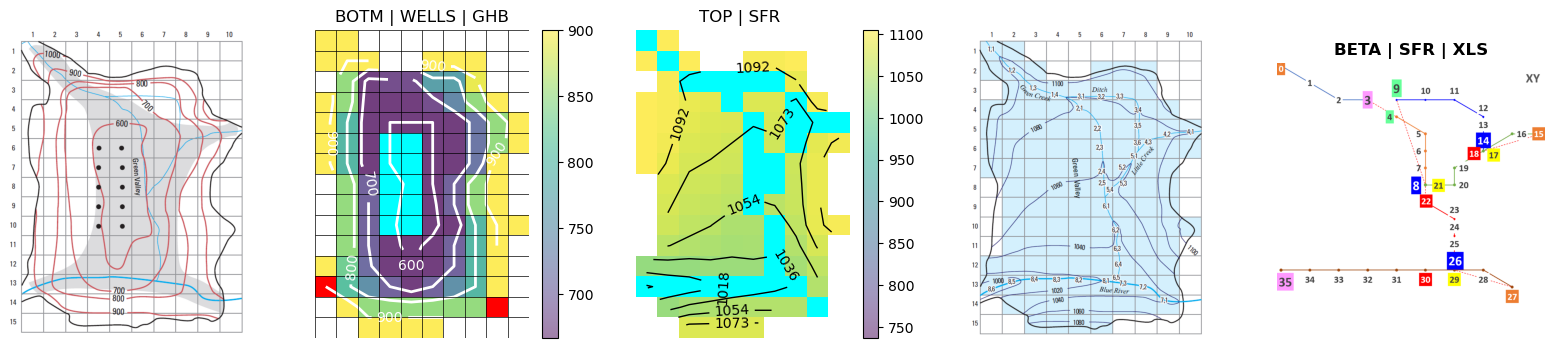

Diversion :  [[3, 0, 9, 'UPTO']]


In [4]:
fig = plt.figure(figsize=(20, 4), dpi=100)                                                               ; VMIN=np.max(botm[0])/1.5 ; VMAX=np.max(botm[0])*.9
ax = fig.add_subplot(151)            ; image=plt.imread(REF1/'SRF1.png')     ; ax.imshow(image) ;ax.axis('off')       
ax = fig.add_subplot(152)            ; mm=flopy.plot.PlotMapView(GWF,ax=ax)   ; CO=mm.plot_array(botm ,vmin=VMIN                 ,vmax=VMAX,masked_values=(0,1e30,-1e30),alpha=0.5) 
cbar=plt.colorbar(CO,ax=ax,format="%.0f")    ; plt.axis('off')               ; CW= mm.contour_array(botm,levels=LEV,linewidths=2,linestyles="-",colors="white",masked_values=(0, 1e30, -1e30)) 
mm.plot_bc("GHB", color="red")  ; mm.plot_bc("WEL",color="cyan",kper=1) ; ax.set_title("BOTM | WELLS | GHB")  ; mm.plot_grid(lw=0.5, color="black")  ; plt.clabel(CW, fmt="%1.0f")

ax = fig.add_subplot(153)            ; ax.set_title("TOP | SFR ")  ;plt.axis('off') ; # ______________________________________________________________________________________
mm=flopy.plot.PlotMapView(GWF,ax=ax)  ;TC=mm.plot_array(top,vmin=np.max(top[0])/1.5,vmax=np.max(top[0]),masked_values=(0,1e30,-1e30),alpha=0.5)      ; cbar=plt.colorbar(TC,ax=ax, format="%.0f")
mm.plot_bc("SFR", color="cyan") ; CV = mm.contour_array(top,levels=LT,linewidths=1,linestyles="-",colors="black",masked_values=(0, 1e30, -1e30))     ; plt.clabel(CV, fmt="%1.0f")

ax = fig.add_subplot(154)            ;image=plt.imread(REF1/'SRF2.png') ;ax.imshow(image) ;ax.axis('off')   
ax = fig.add_subplot(155)            ;image=plt.imread(REF1/'BXLS.png') ;ax.imshow(image) ;ax.axis('off')     ; ax.set_title("BETA | SFR | XLS",fontweight="bold") ; plt.show()

print('Diversion : ', SFR_D)  #; print('WELs_OBS_F:', WEL_S) #import xlwings as xw ; wb = xw.Book('E:/15_REPOS/02_Beta-Me/Beta_xls/11_15_51_SFR.xlsx')  ; wb.sheets['b'].activate()

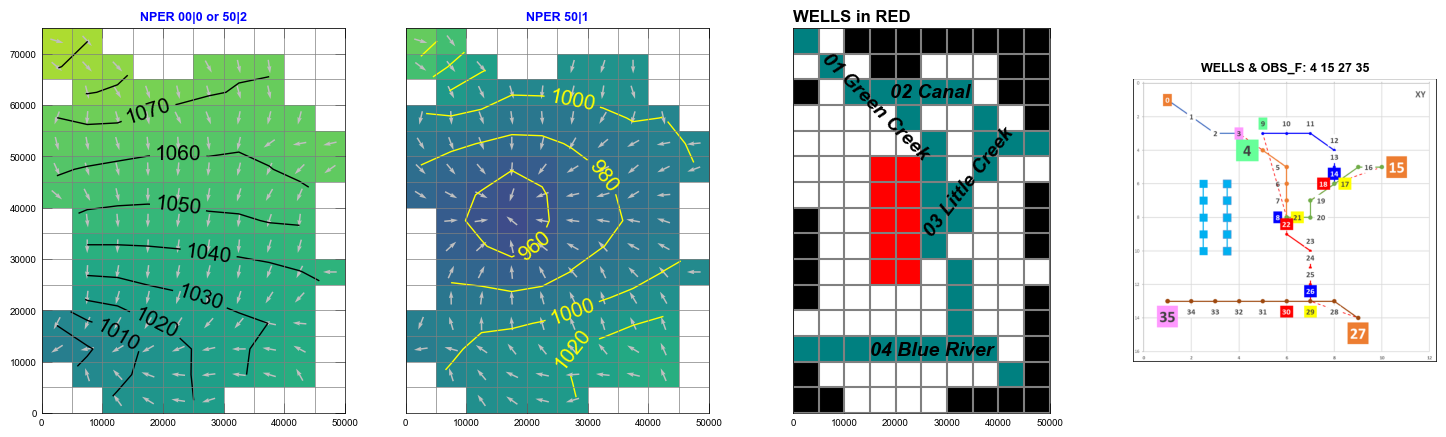

In [5]:
fig = plt.figure(figsize=(18, 5))          ; EX = (0.0,delr*ncol,0.0,delc*nrow)            
with styles.USGSMap():                   # ; print('Min H', round(np.min(head0[0]),0), '____ Min H pump',round(np.min(head1[0]),0))
    ax = fig.add_subplot(141)   # _______________________________________________________________________________________________________    
    mm=flopy.plot.PlotMapView(GWF,ax=ax,extent=EX)  ;HC=mm.plot_array(head0,vmin=900,vmax=1120)     ;ax.set_title('NPER 00|0 or 50|2',fontweight='bold', color='blue')
    CV = mm.contour_array(head0,levels=np.arange(900, 1100, 10),linewidths=1,linestyles="-",colors="black",masked_values=(0, 1e30, -1e30))
    plt.clabel(CV, fmt="%1.0f",fontsize=15) ; mm.plot_vector(QX0, QY0, normalize=True, color="0.75")   ;mm.plot_grid(lw=0.5)  
    ax = fig.add_subplot(142)   # _______________________________________________________________________________________________________
    mn = flopy.plot.PlotMapView(GWF,ax=ax,extent=EX) ;HC=mn.plot_array(head1,vmin=900,vmax=1120,)   ;ax.set_title('NPER 50|1',fontweight='bold',color='b')  
    CV = mn.contour_array(head1,levels=np.arange(900, 1100, 20),linewidths=1,linestyles="-",colors="yellow",masked_values=(0, 1e30, -1e30))
    plt.clabel(CV, fmt="%1.0f",fontsize=15) ; mn.plot_vector(QX1, QY1, normalize=True, color="0.75")   ;mn.plot_grid(lw=0.5)      ; ax.yaxis.set_visible(False) 
    ax = fig.add_subplot(143)
    pmv = flopy.plot.PlotMapView(GWF,) ; pmv.plot_inactive() ; pmv.plot_grid() ; pmv.plot_bc("SFR") ; pmv.plot_bc("WEL", plotAll=True,kper=1)
    styles.heading(ax=ax, heading="WELLS in RED", fontsize=12)                                                      ; ax.yaxis.set_visible(False)  
    styles.add_text(ax,text="01 Green Creek",x=0.10,y=0.65,bold=True,rotation=-45,fontsize=14,) ; styles.add_text(ax, text="02 Canal", x=0.38, y=0.81, bold=True, fontsize=14)
    styles.add_text(ax,text="03 Little Creek",x=0.5,y=0.45,bold=True,rotation=52,fontsize=14,) ; styles.add_text(ax, text="04 Blue River", x=0.30, y=0.14, bold=True, fontsize=14)
    ax = fig.add_subplot(144)   ; image=plt.imread(REF1/'BXLS_2.png') ;ax.imshow(image) ;ax.axis('off')         ; ax.set_title("WELLS & OBS_F: 4 15 27 35",fontweight="bold")        ;plt.show()

**Green Valley Water wants to begin pumping <font color='blue'> 10 public supply wells </font> at the <font color='blue'> rate of 10 ft^3/sec. </font>** <br> <font color='red'> **However, (..)  stream levels dropping to less than 5" or about 0.42 ft could have negative impacts on the trout population.** </font> <br> <font color='blue'> **The task is to find a sustainable long term pumping rates while maintaining in stream flows.** </font>

In [6]:
REACH = {3: ("R01", "Upper Green Creek"),14: ("R02", "Little Creek"),26: ("R03", "Lower Green Creek"),35: ("R04", "Blue River"),}          ;rtops = GWF.sfr.packagedata 

rtops = GWF.sfr.packagedata.array["rtp"]   ; RES = pd.DataFrame(GWF.sfr.output.obs().data)
for rno, (rtag, name) in REACH.items():      STAGE = f"{rtag}_STAGE"       ; rtop = rtops[rno]     ; RES[f"{rtag}_depth"] = RES[STAGE] - rtop
RES['TE']=RES['totim']/(365*86400)         ; RES ;RES.iloc[13:17]

,totim,R01_STAGE,R02_STAGE,R03_STAGE,R04_STAGE,R01_FLOW,R02_FLOW,R03_FLOW,R04_FLOW,R01_depth,R02_depth,R03_depth,R04_depth,TE
13,3.324479e+07,1078.976973,1061.581,1026.388757,993.278260,-35.568709,-0.671083,-5.465668,-147.768209,1.568973,1.036,0.479757,1.403260,1.054185
14,3.792494e+07,1078.974837,1061.581,1026.345889,993.267326,-35.485305,-0.152160,-4.706488,-145.850330,1.566837,1.036,0.436889,1.392326,1.202592
15,4.307311e+07,1078.972232,1060.545,1026.331970,993.259147,-35.383697,0.000000,-4.468153,-144.419837,1.564232,0.000,0.422970,1.384147,1.365839
16,4.873610e+07,1078.969127,1060.545,1026.317236,993.250854,-35.262725,0.000000,-4.221554,-142.975387,1.561127,0.000,0.408236,1.375854,1.545412


In [7]:
THR = 0.43
idxs = np.where(RES["R03_depth"].values < THR)[0]   ; idx = list(sorted(idxs))[0]       ; RAS2 = RES.reset_index()  ; RAS3 = pd.DataFrame(RAS2.iloc[idx])       # H27_depth
years_pumped = (RAS2.loc[idx, "totim"] - RAS2.loc[0, "totim"]) / (365.25 * 86400)       ; print('TE_',f"{years_pumped = :.2f}")    # ; RES3.T  

TE_ years_pumped = 1.36


<font color='orange'> **RES_01 ________________________________________________________________________________________________________________________** </font>

In [8]:
RH = pd.DataFrame(GWF.sfr.output.obs().data)   ; RQ = pd.DataFrame(GWF.sfr.output.obs().data)   ; RNOS = (3,14,26,35,)   ; SFR = GWF.sfr.packagedata.array["rtp"]        ; offsets = []
for RR in RNOS:                     offsets.append(SFR[RR])                                           
OFF = pd.Series(offsets)           ; COL=['R01_STAGE','R02_STAGE','R03_STAGE','R04_STAGE']     

A1=pd.DataFrame(RH['R01_STAGE'].sub(OFF[0], axis=0)) ; A2=pd.DataFrame(RH['R02_STAGE'].sub(OFF[1], axis=0)); A3=pd.DataFrame(RH['R03_STAGE'].sub(OFF[2], axis=0))
A4=pd.DataFrame(RH['R04_STAGE'].sub(OFF[3], axis=0)) ; RH = pd.concat([A1, A2, A3, A4], axis=1)

DE2=pd.read_csv(TA/'green_valley.sfr.obs.csv') ; DE2 = DE2 - DE2.min()                          ; TT = DE2.set_axis(['time','F4','F15','F27','F35','Q4','Q15','Q27','Q35'], axis='columns')
TT['Q4']=TT['Q4']*-1;TT['Q15']=TT['Q15']*-1;TT['Q27']=TT['Q27']*-1;TT['Q35']=TT['Q35']*-1       ; TT['TE'] = TT['time']/(365*86400)                               ### plot_sfr_results(GWF)

<font color='blue'> **MODFLOW_API _________________________________________________________________________** </font>

In [9]:
_DLL_PATH= Path(os.getenv("CONDA_PREFIX"))   ; _DLL_PATH=_DLL_PATH / "Scripts"  ; libmf6 = (_DLL_PATH / f"libmf6.dll").resolve() ; 

In [10]:
%%capture 
def adjust_pumping_callback_rampdown(sim, callback_step):
    irch = 26  ; threshold = 0.43  ; PUMP = -10   ; GWF = sim.get_model()
    if callback_step == Callbacks.timestep_start:
        if sim.kper > 0:    GWF.wel.stress_period_data["q"] = np.full((10,), PUMP)
    if callback_step == Callbacks.iteration_start:
        if sim.kper > 0:
            if sim.iteration == 0:
                sim.allow_convergence = False
                return
            SFR = GWF.sfr                   ; STAGE = SFR.get_advanced_var("stage")    ; TOP = SFR.get_advanced_var("strtop") 
            gr_stage = STAGE[irch]         ; gr_strtop = TOP[irch]                    ; DEPTH = STAGE[irch] - TOP[irch]
            if DEPTH <= threshold:
                sim.allow_convergence = False   ; SPD = GWF.wel.stress_period_data
                if abs(SPD["q"][0]) <= 0.1:       SPD["q"] = 0
                else:                             GWF.wel.stress_period_data["q"] *= 0.90
            else:                                 sim.allow_convergence = True
modflowapi.run_simulation(libmf6, sim_ws, adjust_pumping_callback_rampdown, verbose=False)

<font color='orange'> **RES_02________________________________________________________________________________________________________________________** </font>

In [11]:
BUD=GWF.output.budget()     ; wels = BUD.get_data(text="WEL")[1:] ; totim=np.array(BUD.times[1:]);times=totim-totim[0]     ;PUMP = np.array([r["q"][0] for r in wels]) ; tt=365.25*86400.0
print('Q1=10 (ft3/s) *1.699 = 17 (m3/min)',len(PUMP),'years, .. Q2?')     ; df=pd.DataFrame(data=np.array([times, PUMP]).T,columns=["time","PUMP"]) ;df["time"]/=tt    ;pd.DataFrame(PUMP).T

Q1=10 (ft3/s) *1.699 = 17 (m3/min) 50 years, .. Q2?


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,...,-3.486784,-3.486784,-3.486784,-3.486784,-3.486784,-3.486784,-3.486784,-3.486784,-3.486784,-3.486784


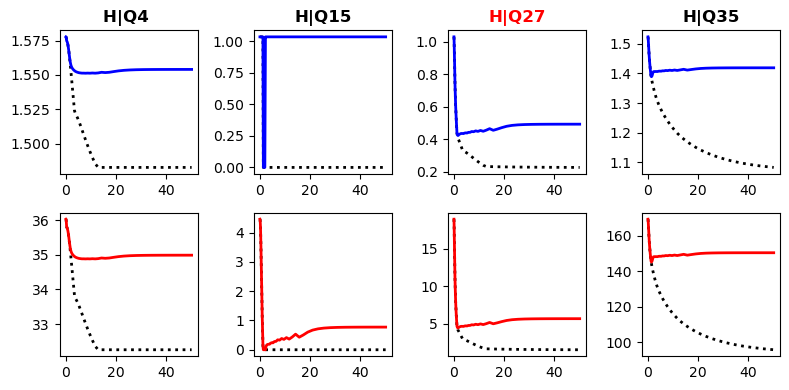

In [12]:
SH = pd.DataFrame(GWF.sfr.output.obs().data)   ; SQ = pd.DataFrame(GWF.sfr.output.obs().data)   ; RNOS = (3,14,26,35,)   ; SFR = GWF.sfr.packagedata.array["rtp"]        ; offsets = []
for RR in RNOS:                     offsets.append(SFR[RR])                                           
OFF = pd.Series(offsets)           ; COL=['R01_STAGE','R02_STAGE','R03_STAGE','R04_STAGE']     

B1=pd.DataFrame(SH['R01_STAGE'].sub(OFF[0], axis=0)) ; B2=pd.DataFrame(SH['R02_STAGE'].sub(OFF[1], axis=0)); B3=pd.DataFrame(SH['R03_STAGE'].sub(OFF[2], axis=0))
B4=pd.DataFrame(SH['R04_STAGE'].sub(OFF[3], axis=0)) ; SH = pd.concat([B1, B2, B3, B4], axis=1)

fig = plt.figure(figsize=(8,4))                                      ;P1='black'  ;P2='dotted'
ax=fig.add_subplot(241) ;ax.plot(TT['TE'],RH.iloc[:,0]    ,lw=2,color=P1,linestyle=P2)   ;ax.plot(TT['TE'],SH.iloc[:,-4]   ,lw=2,color='b');ax.set_title("H|Q4 ",fontweight="bold") 
ax=fig.add_subplot(242) ;ax.plot(TT['TE'],RH.iloc[:,1]    ,lw=2,color=P1,linestyle=P2)   ;ax.plot(TT['TE'],SH.iloc[:,-3]   ,lw=2,color='b');ax.set_title("H|Q15",fontweight="bold")
ax=fig.add_subplot(243) ;ax.plot(TT['TE'],RH.iloc[:,2]    ,lw=2,color=P1,linestyle=P2)   ;ax.plot(TT['TE'],SH.iloc[:,-2]   ,lw=2,color='b');ax.set_title("H|Q27",fontweight="bold", color='r') 
ax=fig.add_subplot(244) ;ax.plot(TT['TE'],RH.iloc[:,3]    ,lw=2,color=P1,linestyle=P2)   ;ax.plot(TT['TE'],SH.iloc[:,-1]   ,lw=2,color='b');ax.set_title("H|Q35",fontweight="bold")
ax=fig.add_subplot(245) ;ax.plot(TT['TE'],RQ.iloc[:, 5]*-1,lw=2,color=P1,linestyle=P2)   ;ax.plot(TT['TE'],SQ.iloc[:, 5]*-1,lw=2,color='r')
ax=fig.add_subplot(246) ;ax.plot(TT['TE'],RQ.iloc[:, 6]*-1,lw=2,color=P1,linestyle=P2)   ;ax.plot(TT['TE'],SQ.iloc[:, 6]*-1,lw=2,color='r')
ax=fig.add_subplot(247) ;ax.plot(TT['TE'],RQ.iloc[:, 7]*-1,lw=2,color=P1,linestyle=P2)   ;ax.plot(TT['TE'],SQ.iloc[:, 7]*-1,lw=2,color='r')
ax=fig.add_subplot(248) ;ax.plot(TT['TE'],RQ.iloc[:, 8]*-1,lw=2,color=P1,linestyle=P2)   ;ax.plot(TT['TE'],SQ.iloc[:, 8]*-1,lw=2,color='r');plt.tight_layout() ;plt.show()

In [13]:
obs = GWF.sfr.output.obs()      ; df = obs.get_dataframe(start_datetime=dt.datetime(2024, 6, 1), timeunit="s")                     ; df.to_csv(TA/"_RES_01.csv") ; #df.head()

TB=Path("./TA/TB");TB.mkdir(exist_ok=True)                                                    ;pd.DataFrame(os.listdir(TB)).to_csv(TB/"_01_LIST.csv")
np.savetxt(TB/"_01_SP.csv",SFR_P,delimiter=",");pd.DataFrame(SFR_C).to_csv(TB/"_02_SC.csv")   ;np.savetxt(TB/"_03_SD.csv",SFR_D,fmt="%s",delimiter=",");pd.DataFrame(SFR_S).to_csv(TB/"_04_SS.csv")
np.savetxt(TB/"_05_IDO.csv",idomain,delimiter=",") ;np.savetxt(TB/"_05_TOP.csv",top,delimiter=",");np.savetxt(TB/"_05_RCH.csv",recharge,delimiter=",")  ;np.savetxt(TB/"_05_SURF_W.csv",surf,delimiter=",")
np.savetxt(TB/"_05_GHB_spd.csv",GHB_S,delimiter=",")  ; pd.DataFrame(OBS_D).to_csv(TB/"_05_OBS_D.csv")  
with open(TB/"_06_WEL_spd.csv", "w", newline="") as ff:       # _____________________________________________ saving
    mm = csv.DictWriter(ff, WEL_S.keys())   ; mm.writeheader()  ; mm.writerow(WEL_S)

with open(TA/"_07_OBS_F.csv", 'w', newline='')   as csvfile:  # _____________________________________________ saving
    writer = csv.writer(csvfile)
n='n'                                                                          ; SFR_P = pd.read_csv(REF1/'Beta'/"Bxls_sfr_P.csv", header=None).values.tolist()   # Bxls_sfr_P.csv
df = pd.read_csv(REF1/'Beta'/"Bxls_sfr_C.csv", header=None).dropna(how='all')  ; SFR_C = df.stack().groupby(level=0).apply(list).tolist()                         # Bxls_sfr_C.csv
n='n'                                                                          ; SFR_S = pd.read_csv(REF1/'Beta'/"Bxls_sfr_S.csv", header=None).values.tolist()   # Bxls_sfr_S.csv

In [14]:
# Beta-Me.